In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from scipy.spatial import distance
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.svm import LinearSVC


## TO DO
* Comparação entre vocabulários
* Comparação entre caracteres?
* Treinar cnn

## Twitter VS Whatsapp
* contas físicas vs contas institucionais
* acessibilidade/elitismo do acesso

In [2]:
#corpus FakeTweet.Br disponibilizado em: https://github.com/prc992/FakeTweet.Br
twitter = pd.read_csv('data/FakeTweetBr.csv')
wpp = pd.read_csv('data/2018/wpp_2018_v20_labeled.csv')

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
twitter['classificacao'].unique()

array(['fake', 'true'], dtype=object)

In [4]:
twitter.head()

,Unnamed: 0,id,subject,text,classificacao,date,retweets,favorites,permalink
0,0,1.124513e+18,macaco marielle,Marielle >BANDIDOS Narco-traficantes-Milícias ...,fake,2019-05-04 0:16,0,0,https://twitter.com/MRTT_/status/1124513050218...
1,1,1.124049e+18,macaco marielle,"Bem, as últimas noticias a respeito disso que ...",fake,2019-05-02 17:33,0,0,https://twitter.com/EvaristoKlebber/status/112...
2,5,1.119295e+18,macaco marielle,@jornalnacional convivi com notícias da Mariel...,fake,2019-04-19 14:41,0,0,https://twitter.com/luiztemper/status/11192950...
3,10,1.114583e+18,macaco marielle,"O Cesari Battisti confessou seus crimes, a esq...",fake,2019-04-06 14:36,0,0,https://twitter.com/GrimoaldoL/status/11145825...
4,11,1.113246e+18,macaco marielle,[Agência Lupa] Verificamos: É falso que Thiago...,true,2019-04-02 22:04,1,0,https://twitter.com/antmarobel/status/11132459...


# VISUALIZAÇÕES
### DISTRIBUIÇÃO DE PALAVRAS

In [5]:
twitter['PALAVRAS'] = [len(s.split()) for s in twitter['text']]

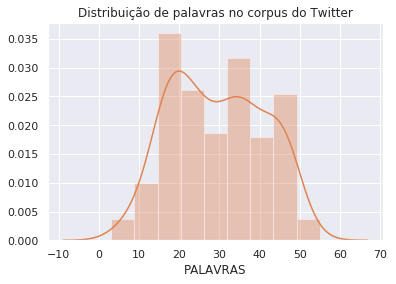

In [6]:
plt.title('Distribuição de palavras no corpus do Twitter')
sns.distplot(twitter['PALAVRAS'], kde = True, color = 'C1')
plt.show()

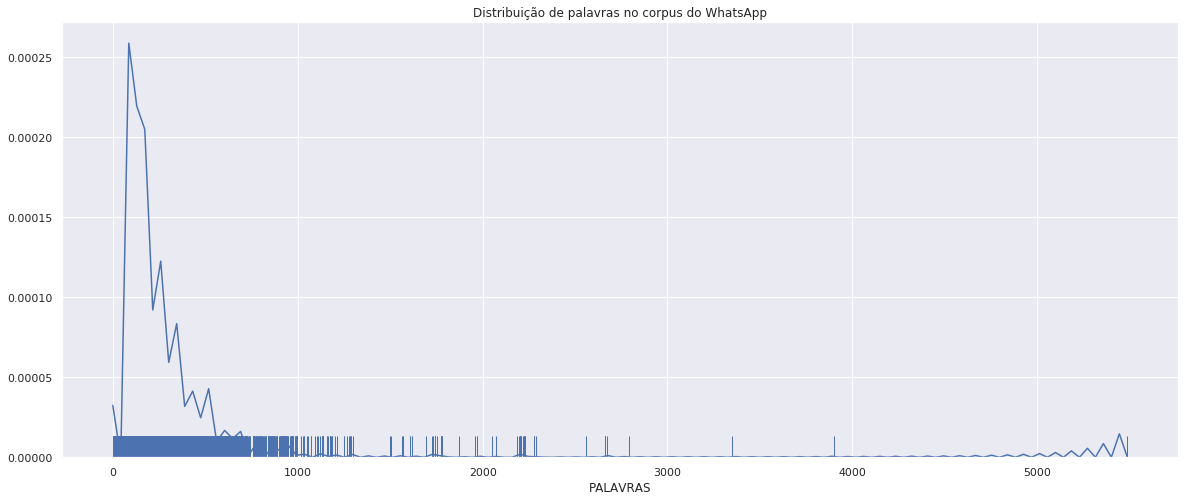

In [7]:
plt.figure(figsize=(20, 8))
plt.title('Distribuição de palavras no corpus do WhatsApp')
sns.distplot(wpp[wpp['MIDIA'] == 0]['PALAVRAS'], hist = False, kde = True, rug = True)
plt.show()

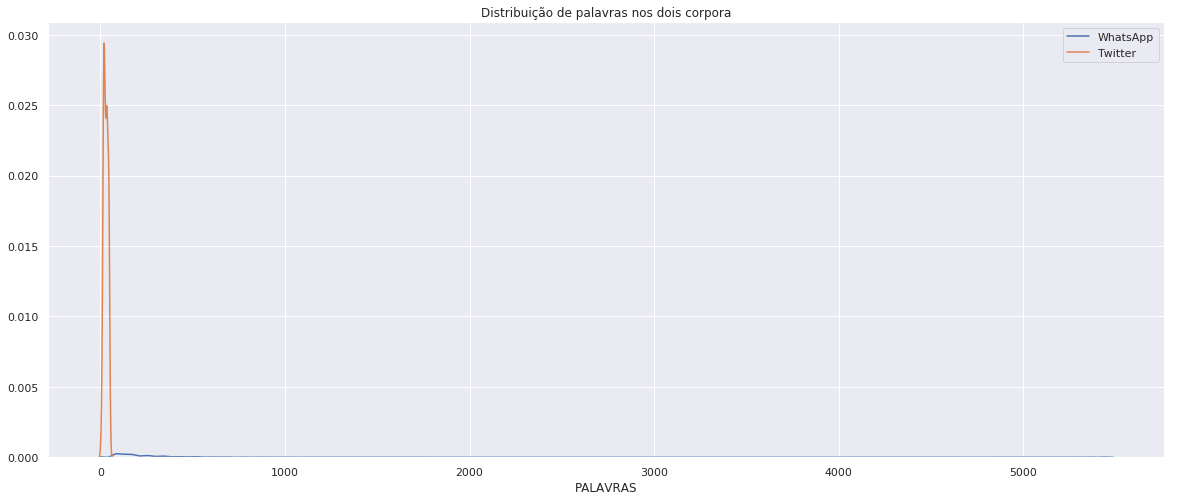

In [8]:
plt.figure(figsize=(20, 8))
plt.title('Distribuição de palavras nos dois corpora')
sns.distplot(wpp[wpp['MIDIA'] == 0]['PALAVRAS'], hist = False, kde = True, label = 'WhatsApp')
sns.distplot(twitter['PALAVRAS'], hist = False, kde = True, label = 'Twitter')
plt.show()

In [9]:
wpp.columns

Index(['ID', 'DATA', 'HORA', 'DDI', 'PAIS', 'PAIS_ISO3', 'DDD', 'ESTADO',
       'GRUPO', 'MIDIA', 'URL', 'CARACTERES', 'PALAVRAS', 'ENCAMINHADA',
       'ENCAMINHAMENTOS', 'MENSAGEM', 'VEC', 'DESINFORMACAO'],
      dtype='object')

In [10]:
#[f(x) if condition else g(x) for x in sequence]

wpp['CLASSE'] = ['fake' if s == 1 else 'non-fake' for s in wpp['DESINFORMACAO']]

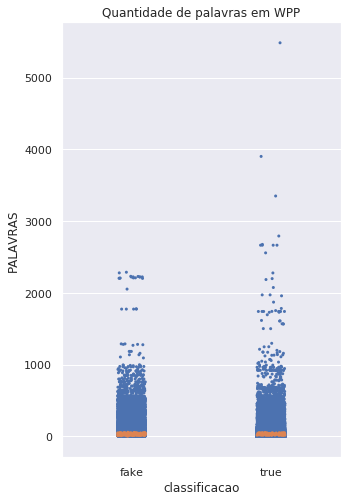

In [11]:
plt.figure(figsize=(5,8))
plt.title('Quantidade de palavras em WPP')
sns.stripplot(y="PALAVRAS", x = 'CLASSE', size = 3, color = 'C0', data=wpp)
sns.stripplot(y="PALAVRAS", x = 'classificacao', data=twitter, size = 3, color = 'C1')
plt.show()

### Distribuição de palavras para as classes

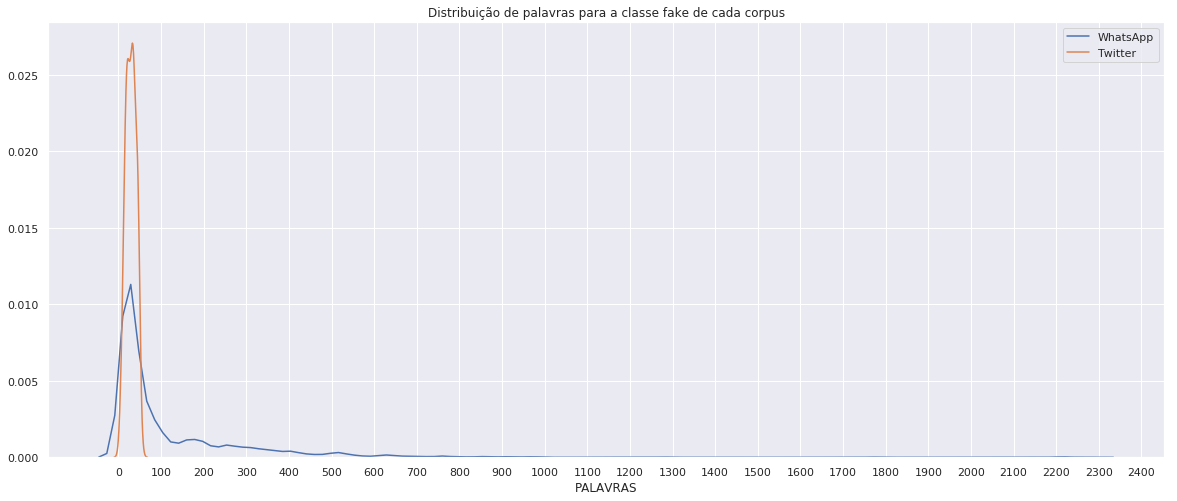

In [12]:
plt.figure(figsize=(20, 8))
plt.title('Distribuição de palavras para a classe fake de cada corpus')
plt.xticks(np.arange(0, 2500, 100))
sns.distplot(wpp[(wpp['MIDIA'] == 0) & (wpp['DESINFORMACAO']==1)]['PALAVRAS'], hist = False, kde = True, label = 'WhatsApp')
sns.distplot(twitter[twitter['classificacao']=='fake']['PALAVRAS'], hist = False, kde = True, label = 'Twitter')
plt.show()

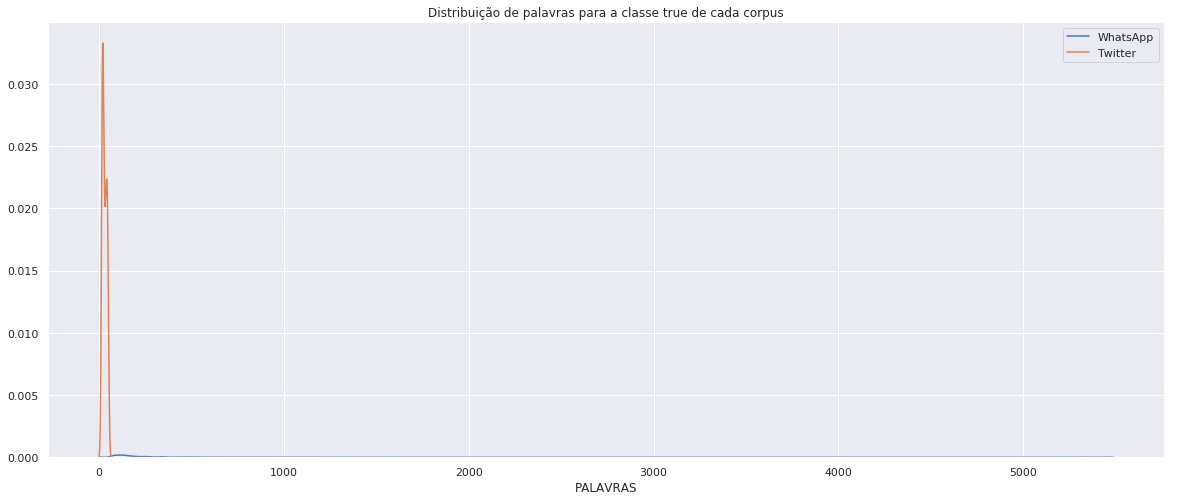

In [13]:
plt.figure(figsize=(20, 8))
plt.title('Distribuição de palavras para a classe true de cada corpus')
#plt.xticks(np.arange(0, 2500, 100))
sns.distplot(wpp[(wpp['MIDIA'] == 0) & (wpp['DESINFORMACAO']==0)]['PALAVRAS'], hist = False, kde = True, label = 'WhatsApp')
sns.distplot(twitter[twitter['classificacao']=='true']['PALAVRAS'], hist = False, kde = True, label = 'Twitter')
plt.show()

# VOCABULARIES AND SIMILAR DOCUMENTS

In [32]:
twi_set = set(' '.join(list(twitter['text'])).split())
print('Twitter')
print('Size of vocabulary:', len(twi_set))
print('Unique documents:', len(twitter['text'].unique()))
print()
wpp_set = set(' '.join(list(wpp['MENSAGEM'])).split())
print('WhatsApp')
print('Size of vocabulary:', len(wpp_set))
print('Unique documents:', len(wpp['MENSAGEM'].unique()))
print()
print('Vocab')
print('Intersection:',len(twi_set.intersection(wpp_set)))
twi_perc = len(twi_set.intersection(wpp_set))/len(twi_set)
print('Percentage in twitter: %0.2f' % twi_perc)
wpp_perc = len(twi_set.intersection(wpp_set))/len(wpp_set)
print('Percentage in whatsapp: %0.2f' % wpp_perc)
print('Diference (whatsapp - twitter):',len(wpp_set.difference(twi_set)))



Twitter
Size of vocabulary: 3044
Unique documents: 278

WhatsApp
Size of vocabulary: 206350
Unique documents: 114517

Vocab
Intersection: 2220
Percentage in twitter: 0.73
Percentage in whatsapp: 0.01
Diference (whatsapp - twitter): 204130


In [33]:
vectorizer = TfidfVectorizer()
vectorizer.fit(wpp['MENSAGEM'])

TfidfVectorizer()

In [36]:
wpp_tfid = vectorizer.transform(wpp['MENSAGEM'])
twitter_tfid = vectorizer.transform(twitter['text'])

In [38]:
cosine_similarities = linear_kernel(twitter_tfid, wpp_tfid)
cosine_similarities.shape

(279, 282681)

In [53]:
max_sim = cosine_similarities.max(axis = 1)
max_arg = cosine_similarities.argmax(axis = 1)
max_sim.shape

(279,)

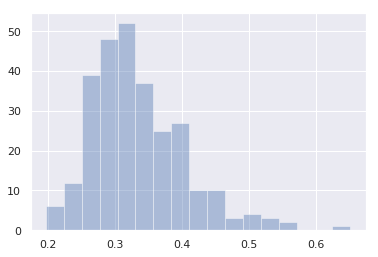

In [54]:
sns.distplot(max_sim,kde=False)

In [64]:
best_match = [wpp.iloc[idx]['MENSAGEM'] for idx in max_arg] 
df_sim = pd.DataFrame({'text_twitter': twitter['text'],
         'best_match':best_match,
         'sim': max_sim})

In [69]:
df_sim[df_sim['sim']>0.6]['text_twitter'].values[0]

'Não é rachadura . É uma junta de dilatação da ponte rio niteroi'

In [56]:
mask = max_sim > 0.6 
max_arg[mask]

array([89397])

In [61]:
wpp.iloc[max_arg[mask]]['MENSAGEM'].values[0]

'Hoje! Ponte Rio-Niteroi...'

# COMPARAÇÃO DE CLASSIFICADORES

* Treinar e testar modelos com corpus do twitter
* treinar modelos com corpus do twitter e testar no corpus wpp
* treinar modelos com corpus do wpp e testar no corpus do wpp

dúvidas: é necessário validação?

In [104]:
y = [1 if s == 'fake' else 0 for s in twitter['classificacao']]
sentences = twitter['text']

In [105]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, 
                                                                    stratify = y, random_state=1000)


In [106]:
y = wpp['DESINFORMACAO']
sentences = wpp['MENSAGEM']

In [107]:
sentences_train_wpp, sentences_test_wpp, y_train_wpp, y_test_wpp = train_test_split(sentences, y, test_size=0.33, 
                                                                    stratify = y, random_state=1000)

In [108]:
#vetorização tf-idf
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

X_train_wpp = vectorizer.transform(sentences_train_wpp)
X_test_wpp = vectorizer.transform(sentences_test_wpp)

In [109]:
print(X_train.shape)
print(X_train_wpp.shape)

(223, 2088)
(189396, 2088)


In [110]:
def getTestMetrics(y_test, y_pred):
    #acurácia
    print('accuracy: ', metrics.accuracy_score(y_test, y_pred))
    #precision, recall, f1
    print(metrics.classification_report(y_test, y_pred))
    
    #matriz de confusão
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    group_names = ['VN','FP','FN','VP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.title('Regressão Logística')
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    #auroc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print('AUC: ',roc_auc)
    #plot
    #plt.figure()
    lw = 2
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()    

accuracy:  0.7321428571428571
              precision    recall  f1-score   support

           0       1.00      0.17      0.29        18
           1       0.72      1.00      0.84        38

    accuracy                           0.73        56
   macro avg       0.86      0.58      0.56        56
weighted avg       0.81      0.73      0.66        56

AUC:  0.5833333333333333


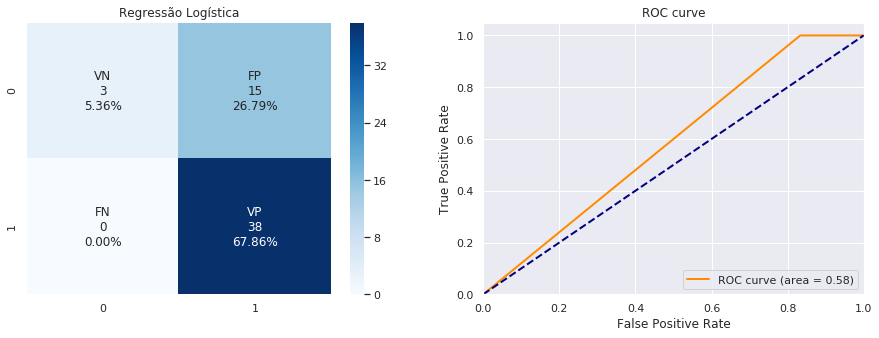

In [111]:
# regressão logística sem balanceamento
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)
getTestMetrics(y_test, y_pred)

In [112]:
#balanceamento
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

accuracy:  0.875
              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.88      0.95      0.91        38

    accuracy                           0.88        56
   macro avg       0.87      0.83      0.85        56
weighted avg       0.87      0.88      0.87        56

AUC:  0.8347953216374268


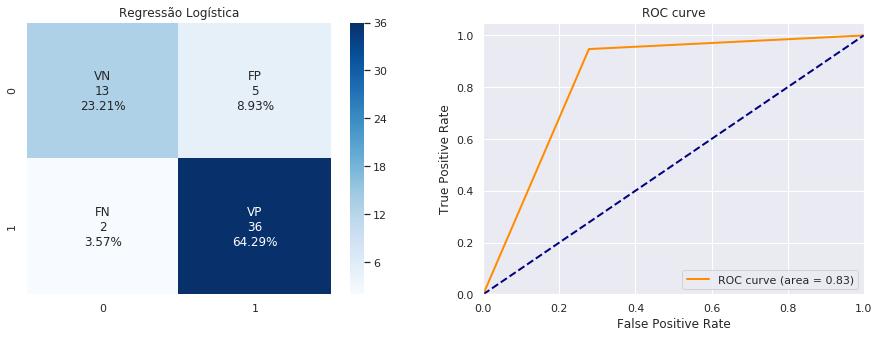

In [113]:
# regressão logística com balanceamento
clf = LogisticRegression().fit(X_res, y_res)
y_pred = clf.predict(X_test)
getTestMetrics(y_test, y_pred)

accuracy:  0.8571428571428571
              precision    recall  f1-score   support

           0       0.92      0.61      0.73        18
           1       0.84      0.97      0.90        38

    accuracy                           0.86        56
   macro avg       0.88      0.79      0.82        56
weighted avg       0.87      0.86      0.85        56

AUC:  0.7923976608187135


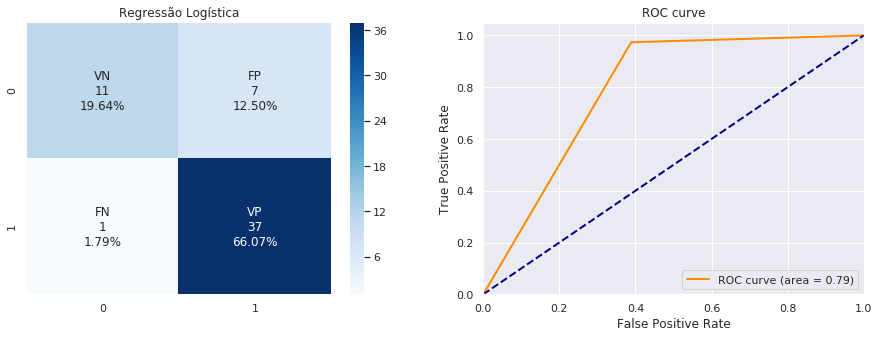

In [114]:
#SVM linear
clf2 = SGDClassifier().fit(X_res, y_res)
y_pred = clf2.predict(X_test)
getTestMetrics(y_test, y_pred)

accuracy:  0.8392857142857143
              precision    recall  f1-score   support

           0       0.70      0.89      0.78        18
           1       0.94      0.82      0.87        38

    accuracy                           0.84        56
   macro avg       0.82      0.85      0.83        56
weighted avg       0.86      0.84      0.84        56

AUC:  0.8523391812865496


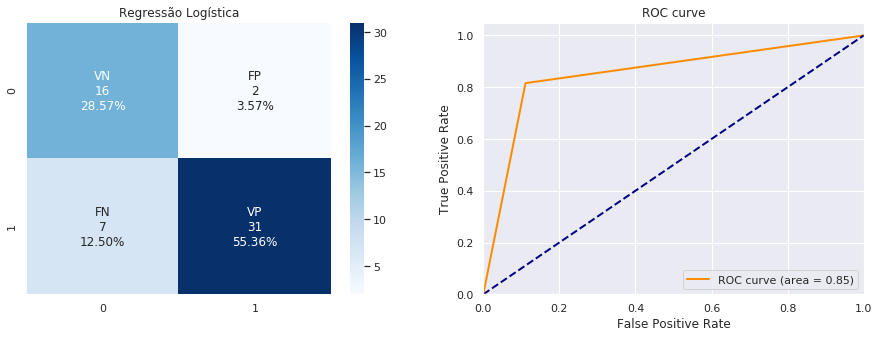

In [115]:
#Naive-Bayes
clf3 = MultinomialNB().fit(X_res, y_res)
y_pred = clf3.predict(X_test)
getTestMetrics(y_test, y_pred)

### Passo 2: testando modelos treinados com twitter no corpus wpp (tarefa: detectar desinformação em maio a diálogos)

accuracy:  0.11414482499866002
              precision    recall  f1-score   support

           0       0.94      0.08      0.15     89413
           1       0.04      0.89      0.08      3872

    accuracy                           0.11     93285
   macro avg       0.49      0.49      0.11     93285
weighted avg       0.91      0.11      0.15     93285

AUC:  0.4855105355194065


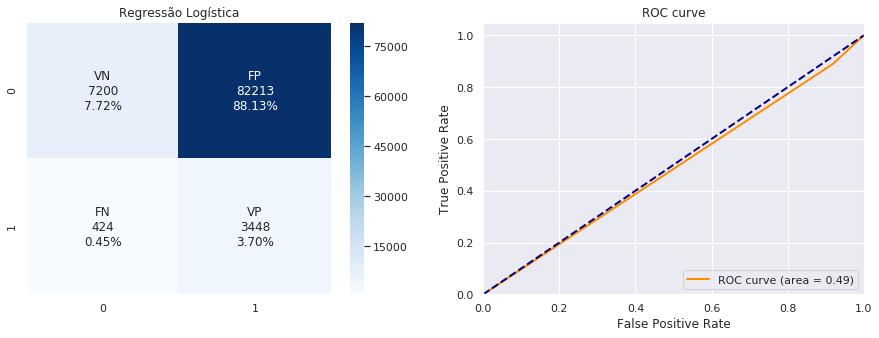

In [116]:
#regressão logística
y_pred = clf.predict(X_test_wpp)
getTestMetrics(y_test_wpp, y_pred)

accuracy:  0.08841721605831591
              precision    recall  f1-score   support

           0       0.94      0.05      0.10     89413
           1       0.04      0.93      0.08      3872

    accuracy                           0.09     93285
   macro avg       0.49      0.49      0.09     93285
weighted avg       0.91      0.09      0.10     93285

AUC:  0.4904971586143158


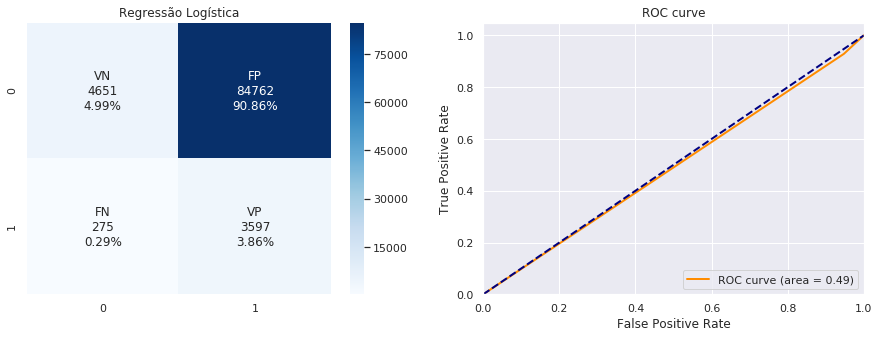

In [117]:
#svm
y_pred = clf2.predict(X_test_wpp)
getTestMetrics(y_test_wpp, y_pred)

### Treinando e testando com corpus wpp (Task C)

In [120]:
#balanceamento
X_res_wpp, y_res_wpp = sm.fit_resample(X_train_wpp, y_train_wpp)

/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy:  0.8890818459559414
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     89413
           1       0.26      0.93      0.41      3872

    accuracy                           0.89     93285
   macro avg       0.63      0.91      0.67     93285
weighted avg       0.97      0.89      0.92     93285

AUC:  0.9094011323325236


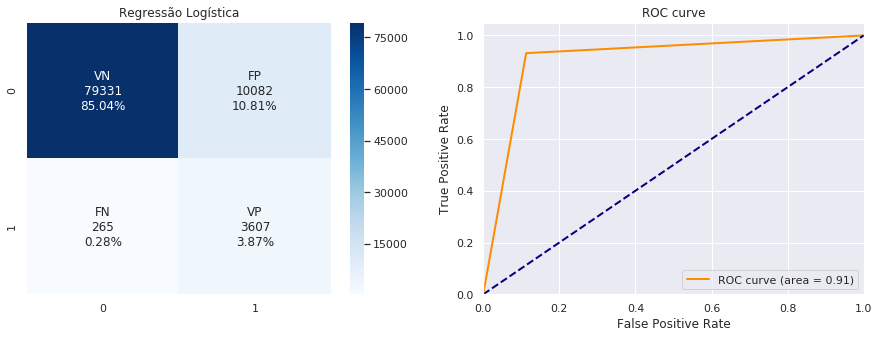

In [123]:
#Regressão logística
clf = LogisticRegression().fit(X_res_wpp, y_res_wpp)
y_pred = clf.predict(X_test_wpp)
getTestMetrics(y_test_wpp, y_pred)

accuracy:  0.8987940183309213
              precision    recall  f1-score   support

           0       1.00      0.90      0.94     89413
           1       0.28      0.93      0.43      3872

    accuracy                           0.90     93285
   macro avg       0.64      0.91      0.69     93285
weighted avg       0.97      0.90      0.92     93285

AUC:  0.9119967056369397


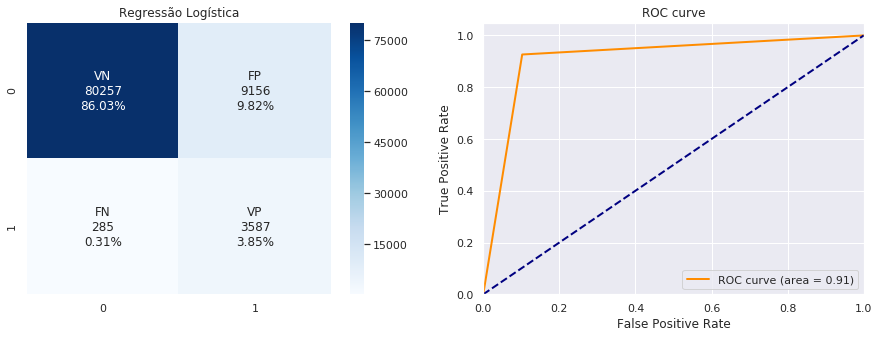

In [124]:
#SVM linear
clf2 = LinearSVC().fit(X_res_wpp, y_res_wpp)
y_pred = clf2.predict(X_test_wpp)
getTestMetrics(y_test_wpp, y_pred)